#PROBLEM : SPAM CLASSIFICATION

When we look at any of our e-mail accounts, we often find that few emails are classified as spam. Similarly, some text messages that are received on the phone are also classified as spam based on a set of characteristics such as certain words, sentence formulation and so on.

In this assignment, we are going to address this problem of detecting SPAM or HAM messages with the help of Naive Bayes algorithm. Dataset contains messages with their label that classifies the messages into either ham or spam.

###Setting up Environment

In [1]:
#Imports
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

###EDA

In [4]:
#Since the file contains additional empty columns, we filter them out while reading
df = pd.read_csv('spam.csv', sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"] )
print(df.shape)
df.head()

(5572, 2)


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Observation :  We have 5572 messages and 2 columns. 

Since the name of the columns are vague, we will rename them to names close the description of the data they corresponds to. Thus, we rename v1 : spam_or_ham and v2 : message. 

In [6]:
df = df.rename(columns = {"v1" : "spam_or_ham" , "v2" : "message"})  #{org:new}
df.head(5)

,spam_or_ham,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


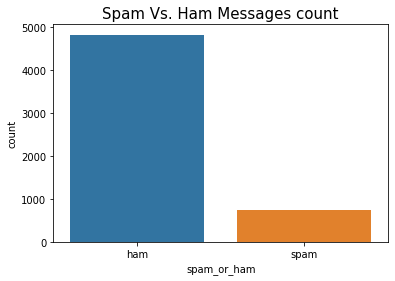

ham     4825
spam     747
Name: spam_or_ham, dtype: int64


In [7]:
#Check distribution of spam and ham

plt.figure(figsize = None)
plt.title("Spam Vs. Ham Messages count", fontsize = 15)
sns.countplot(data=df, x ='spam_or_ham' ) #single categorical var
plt.show()

print(df['spam_or_ham'].value_counts())

Observation : the number of spam messages are comparatively much less than number of ham messages. 

This creates unbalance in data distribution which affects training of the model. Thus, sampling of data is required.

In [10]:
from sklearn.utils import resample

df_majority = df[df['spam_or_ham'] == 'ham']
df_minority = df[df['spam_or_ham'] == 'spam']
print("Inital", "Ham: ", df_majority.shape, "Spam: ",df_minority.shape)

spam_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)
print("Upsampled Spam : ",spam_upsample.shape)

df_upsampled = pd.concat([ df_majority, spam_upsample])  # concat two data frames i.e. majority class data set and upsampled minority class data set
df_upsampled = df_upsampled.sample(frac = 1)
print("Total (Spam + Ham) :", df_upsampled.shape)

Inital Ham:  (4825, 2) Spam:  (747, 2)
Upsampled Spam :  (4825, 2)
Total (Spam + Ham) : (9650, 2)


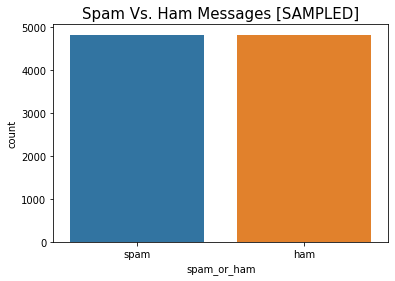

spam    4825
ham     4825
Name: spam_or_ham, dtype: int64


In [23]:
plt.title("Spam Vs. Ham Messages [SAMPLED]", fontsize = 15)
sns.countplot(data=df_upsampled, x ='spam_or_ham' ) #single categorical var
plt.show()
print(df_upsampled['spam_or_ham'].value_counts())

###Train-Test Split

In [30]:
## Considering 3000 spam and 3000 ham data points
spam_data_points_train = df_upsampled[ df_upsampled['spam_or_ham']=='spam' ].iloc[0:3000]
ham_data_points_train = df_upsampled[df_upsampled['spam_or_ham']=='ham'].iloc[0:3000]
print("Train", spam_data_points_train.shape, ham_data_points_train.shape )

## Considering the remaining data points for test
spam_data_points_test = df_upsampled[df_upsampled['spam_or_ham']=='spam'].iloc[3000: ]
ham_data_points_test = df_upsampled[df_upsampled['spam_or_ham']=='ham'].iloc[3000:]
print("Test", spam_data_points_test.shape, ham_data_points_test.shape )

## Concatenate the training ham and spam messages
X_train = pd.concat([spam_data_points_train['message'], ham_data_points_train['message']])
## Concatenating the training ham and spam outputs
y_train = pd.concat([spam_data_points_train['spam_or_ham'], ham_data_points_train['spam_or_ham']])
print("Debug Train", X_train.shape, y_train.shape )

## Concatenating the test ham and spam messages
X_test = pd.concat([spam_data_points_test['message'], ham_data_points_test['message']])
## Concatenating the test ham and spam outputs
y_test = pd.concat([spam_data_points_test['spam_or_ham'], ham_data_points_test['spam_or_ham']])
print("Debug Test", X_test.shape, y_test.shape )

Train (3000, 2) (3000, 2)
Test (1825, 2) (1825, 2)
Debug Train (6000,) (6000,)
Debug Test (3650,) (3650,)


### Preprocess the messages (Cleaning)
The message contains links, punctuation, stopwords and many other words that don't have significane for prediction in the Naive Bayes model.

We implement text-preprocessing to remove punctions, stopwords and links from the messages. 

Also, it is essential to convert all the words into lower case so that same words are not treated differently because of their case.

We also perform stemming in order to reduce the words with same roots.

Additionally, the ham and spam labels are encoded into integers [0,1].

In [17]:
import string
import re
import nltk

def clean_message(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        messages_cleaned: a list of words containing the processed message. 

    '''
    stopwords = nltk.corpus.stopwords.words('english')
    ps = nltk.PorterStemmer()
    
    message = re.sub(r"(www|http:|https:)+[\S]+[\w]", "", message)
    messages_cleaned = "".join([word.lower() for word in message if word not in string.punctuation])
    tokens = re.split("\W+",messages_cleaned)
    messages_cleaned = [ps.stem(word) for word in tokens if word not in stopwords]

    return messages_cleaned

print("debug", clean_message("hello! testing clean function. I hope it works! http://testurl.com www.wow.com okay!"))

debug ['hello', 'test', 'clean', 'function', 'hope', 'work', 'okay']


In [31]:
## With the use of mapping function, we replace the label in the form of string to an integer. 

output_map = {'ham': 0, 'spam': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)
print("Debug Map : \n",y_test[1:5])

Debug Map : 
 2710    1
4899    1
5540    1
3124    1
Name: spam_or_ham, dtype: int64


### Count the frequency of words

In [32]:
def find_occurrence(frequency, word, label):
    '''
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears.
    '''
    key = (word, label)
    if key in frequency.keys():
      n = frequency[key] 
    else :
      n = 0
    return n

In [33]:
def message_counter(output_occurrence, messages, spam_or_ham):
    '''
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        messages: a list of messages
        spam_or_ham: a list corresponding to the sentiment of each message (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    '''
    ## Steps :
    # define the key, which is the word and label tuple
    # if the key exists in the dictionary, increment the count
    # else, if the key is new, add it to the dictionary and set the count to 1
    for label, message in zip(spam_or_ham, messages):
        for word in clean_message(message):
            key = (word,label)
            if key in output_occurrence :
              output_occurrence[key] += 1 #{word,label : count}
            else :
              output_occurrence[key] = 1
    return output_occurrence

In [34]:
#Testing the above function
result = {}
messages = ['get offer upto 20%', 'I am coming now', 'Click on the link www.viv', 'get a latest car', 'canvas class scheduled']
ys = [1, 0, 1, 1, 0]
message_counter(result,messages, ys)

{('', 1): 1,
 ('20', 1): 1,
 ('canva', 0): 1,
 ('car', 1): 1,
 ('class', 0): 1,
 ('click', 1): 1,
 ('come', 0): 1,
 ('get', 1): 2,
 ('latest', 1): 1,
 ('link', 1): 1,
 ('offer', 1): 1,
 ('schedul', 0): 1,
 ('upto', 1): 1}

In [35]:
freqs = message_counter({}, X_train, y_train)
freqs

{('free', 1): 935,
 ('1st', 1): 130,
 ('week', 1): 272,
 ('no1', 1): 49,
 ('nokia', 1): 320,
 ('tone', 1): 325,
 ('4', 1): 484,
 ('ur', 1): 591,
 ('mob', 1): 122,
 ('everi', 1): 142,
 ('txt', 1): 654,
 ('87077', 1): 23,
 ('get', 1): 369,
 ('txting', 1): 61,
 ('tell', 1): 90,
 ('mate', 1): 63,
 ('zed', 1): 27,
 ('pobox', 1): 71,
 ('36504', 1): 45,
 ('w45wq', 1): 37,
 ('norm150pton', 1): 37,
 ('16', 1): 219,
 ('privat', 1): 79,
 ('2004', 1): 39,
 ('account', 1): 76,
 ('statement', 1): 63,
 ('0784987', 1): 8,
 ('show', 1): 149,
 ('786', 1): 21,
 ('unredeem', 1): 64,
 ('bonu', 1): 98,
 ('point', 1): 64,
 ('claim', 1): 469,
 ('call', 1): 1473,
 ('08719180219', 1): 8,
 ('identifi', 1): 64,
 ('code', 1): 120,
 ('45239', 1): 17,
 ('expir', 1): 69,
 ('060505', 1): 8,
 ('urgent', 1): 230,
 ('1', 1): 137,
 ('membership', 1): 7,
 ('å', 1): 1226,
 ('100000', 1): 7,
 ('prize', 1): 439,
 ('jackpot', 1): 7,
 ('word', 1): 79,
 ('81010', 1): 7,
 ('tc', 1): 172,
 ('lccltd', 1): 7,
 ('4403ldnw1a7rw18', 1)

In [40]:
def generate_vocab(X_train):
  vocab = set()
  for pair in freqs:
    word = pair[0]
    vocab.add(word)
  return vocab
len(generate_vocab(X_train))
# Training data has 6564 unique words after preprocessing

6564

###Training

In [41]:
import math 

def train_naive_bayes(freqs, train_x, train_y):
    '''
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of messages
        train_y: a list of labels correponding to the messages (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0


    # calculate V, the number of unique words in the vocabulary
    vocab = generate_vocab(train_x)
    V = len(vocab)

    # calculate num_pos and num_neg - the total number of positive and negative words for all documents
    num_pos = num_neg = 0
    frequency_dict = freqs
    for pair in frequency_dict.keys():

        # if the label is positive (greater than zero)
        if pair[1] == 1:
            # Increment the number of positive words by the count for this (word, label) pair
            num_pos = num_pos + 1

        # else, the label is negative
        else:
            # increment the number of negative words by the count for this (word,label) pair
            num_neg = num_neg + 1

    # Calculate num_doc, the number of documents
    num_doc = len(train_y)

    # Calculate D_pos, the number of positive documents 
    pos_num_docs = len([ y for y in y_train if y == 1])

    # Calculate D_neg, the number of negative documents 
    neg_num_docs = len([ y for y in y_train if y == 0])

    # Calculate logprior
    logprior = np.log(pos_num_docs) - np.log(neg_num_docs)
       
    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = find_occurrence(frequency_dict,word,1)
        freq_neg = find_occurrence(frequency_dict,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos+1)/(num_pos + V)
        p_w_neg = (freq_neg+1)/(num_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [42]:
logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
6564


In [43]:
import math
def naive_bayes_predict(message, logprior, loglikelihood):
    '''
    Params:
        message: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the message (if found in the dictionary) + logprior (a number)

    '''
    
     # process the message to get a list of words
    word_l = clean_message(message)

    # initialize probability to zero
    total_prob = 0

    # add the logprior
    total_prob += (logprior)

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood.keys():
            # add the log likelihood of that word to the probability
            #print(loglikelihood[word], word)
            total_prob = total_prob + loglikelihood[word]
            total_prob = format_log(total_prob)
    return total_prob

#Ensure prob is [0,1]
def format_log(prob):
  if prob > 0 :
    return 1
  else :
    return 0

In [46]:
my_message = 'She smiled.'
p = naive_bayes_predict(my_message, logprior, loglikelihood)
print('Prediction:', p)

Prediction: 0


###Testing

In [47]:
from nltk.corpus.reader.knbc import test
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of messages
        test_y: the corresponding labels for the list of messages
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of messages classified correctly)/(total # of message)
    """
    accuracy = 0  
    
    y_hats = []
    for message in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(message, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        # append the predicted class to the list y_hats
        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1 - error
   
    return accuracy

#print(test_naive_bayes(X_test, y_test, logprior, loglikelihood))
test_naive_bayes(X_test, y_test, logprior, loglikelihood)

0.7901369863013699

In [50]:
#Testing
for message in ['get an offer', 'get the latest movie review', 'order iphone', 'I am on a meeting']:
    p = naive_bayes_predict(message, logprior, loglikelihood)
    print(f'{message} -> {int(p)}')

get an offer -> 1
get the latest movie review -> 1
order iphone -> 1
I am on a meeting -> 0
